<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/chmntz_Lab3/Lab3/chmntz_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Approximation**
Carl Chemnitz

# **Abstract**
This lab dicusses and implements a numerical method to approximate a function, specifically univariable functions.

# **Set up environment**
To have access to the necessary modules you have to run this cell.

In [57]:
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# **Introduction**

$L^2$ is the mathematical space of square-integrable functions that can be used to approximate a function. This is done by constructing a piecewise linear function approximation and projecting it over a mathematical mesh. The projection can be computed as
$$P_Nf(x)=\sum_{j=1}^{N}\alpha_j\phi_j(x),$$
(From 9.5 Projection methods), where $\alpha=(\alpha_1,\dots,\alpha_N)^T$ is the cooridnates of $f_N$ in the basis $\{\phi_{j}\}_{j=1}^N$.

A mesh is a sets of intervals within a set of domains. In this case, the $L^2$ space is projected over a 1D mesh, which means the mesh is a set of intervals $I=[a,b]$, within a single domain,
$$T_h={I_k}.$$

# **Methods**

## $L^2$ projection to piecewise linear approximation over mesh in 1D

The mass matrix is a tridiagonal sparse matrix as $a_{ij}=0,\ \forall i,j: |i-j|>1$. The 3 elements each row, $a_{kk-1}$, $a_{kk}$, and $a_{kk+1}$ can be simplified and approximated to
$$a_{kk-1}=(\phi_k,\phi_{k-1})=\cdots=\frac{h_k}{6},$$
$$a_{kk}=(\phi_k,\phi_{k})=\cdots=\frac{h_k}{3}+\frac{h_{k+1}}{3},$$
$$a_{kk+1}=(\phi_k,\phi_{k+1})=\cdots=\frac{h_{k+1}}{6}.$$
All steps of the simpification can be found on page 201-202 in *Methods in Computational Science*. Since it is much more efficient to compute all integrals over $I_k$ before continuing to $I_{k+1}$, we get that the local mass matrix is
$$A^{I_k}=\frac16\begin{pmatrix}2 & 1 \\ 1 & 2\end{pmatrix}h_i.$$
This we can compute the mass matrix as
$$A=\begin{pmatrix}
\frac{h_1}{3} & \frac{h_1}{6} & & \\
\frac{h_1}{6} & \frac{h_1}{6} & & \\
 & & & \\
 & & &
\end{pmatrix}+\begin{pmatrix}
 & & & \\
 & \frac{h_2}{3} & \frac{h_2}{6} & \\
 & \frac{h_2}{6} & \frac{h_2}{6} & \\
 & & &
\end{pmatrix}+\cdots+\begin{pmatrix}
 & & & \\
 & & & \\
 & & \frac{h_N}{3} & \frac{h_N}{6} \\
 & & \frac{h_N}{6} & \frac{h_N}{6}
\end{pmatrix}.$$

The implementation was based on the algorithm presented on page 16 from [*Finite Element Methods*](https://www.it.uu.se/edu/course/homepage/fem/ht13/skript).

In [58]:
def local_matrix(A: np.array, I: np.array, k: np.integer) -> np.array:
    h_k = abs(I[k+1] - I[k])
    A[k+0, k+0] += h_k / 3
    A[k+0, k+1] += h_k / 6
    A[k+1, k+0] += h_k / 6
    A[k+1, k+1] += h_k / 3
    # Doesn't require that we return A,
    # the array's values are changed
    # and works similiar to pointer in C
    return A

The load vector is computed from
$$b_k=(f,\phi_k)=\int_0^1f(x)\phi_k(x)dx=\int_{I_k}f(x)\lambda_{k,1}(x)dx+\int_{I_{k+1}}f(x)\lambda_{k+1,0}(x)dx,$$
which is given as equation (9.20) in *Methods in Computational Science*. However, as the same book states, it is more efficient to compute the entire $I_k$ before moving to $I_{k+1}$, which gives the element vector
$$b_i^k=\int_{I_k}f(x)\lambda_{k,i}(x)dx.$$
It can be written also be written as
$$b_i\approx f(x_i)\frac{h_i+h_{i+1}}{2},$$
when using the trapezoidal rule as given on page 15 in [*Finite Element Methods*](https://www.it.uu.se/edu/course/homepage/fem/ht13/skript). This gives that
$$b=
\begin{pmatrix}
f(x_0)\frac{h_1}{2} \\
f(x_1)\frac{h_1+h_2}{2} \\
\dots \\
f(x_{N-1})\frac{h_{N-1}+h_N}{2} \\
f(x_{N})\frac{h_N}{2}
\end{pmatrix}=\begin{pmatrix}
f(x_0) \\
f(x_1) \\
0\\
\dots \\
0
\end{pmatrix}\frac{h_1}{2}+\begin{pmatrix}
0 \\
f(x_1) \\
f(x_2)\\
0 \\
\dots
\end{pmatrix}\frac{h_2}{2}+\dots+\begin{pmatrix}
0 \\
0 \\
0 \\
f(x_{N-1}) \\
f(x_N)
\end{pmatrix}\frac{h_N}{2}$$

The algorithm to compute assembly of the local vector is based on equation (9.20) and example 9.9 from the *Methods in Computation Science* and aided by the algorithm from *Assembly of local vector* from [*Finite Element Methods*](https://www.it.uu.se/edu/course/homepage/fem/ht13/skript).

In [59]:
def local_vector(b: np.array, I: np.array, f: Callable, k: np.integer) -> np.array:
    h_k = abs(I[k+1] - I[k])
    b[k+0] += f(I[k+0]) * 0.5 * h_k
    b[k+1] += f(I[k+1]) * 0.5 * h_k
    # Doesn't require that we return A,
    # the array's values are changed
    # and works similiar to pointer in C
    return b

The overall algorithm uses the two algorithm given above and combines it with `assembly_system` (algorithm 9.2) from *Methods in Computational Science* and improves it. We know that the function will be linear, we already know that $q=1$. In my implementation, the local calculations are added to the global matrix and vector in the same step and requires only one for loop instead of 3 as in the given algorithm.

In [60]:
def proj_pw_linear_approx(f: Callable, I: np.array) -> np.array:
    n = len(I)
    A = np.zeros([n, n])
    b = np.zeros([n])

    for k in range(n - 1):
        # Not necessary to make subinterval
        # k can be used with I to define subinterval without creating I_k
        # I_k = np.array([k, k + 1])
        local_matrix(A, I, k)
        local_vector(b, I, f, k)

    return np.linalg.solve(A, b)

# **Results**

We construct a polynomial function $f$ of an arbitrary degree $n=7$. This will be used to test the implemented solution.

In [61]:
f = lambda x : 3*x**7 + 1*x**5 - 2*x**3

We create a interval with three different numbers of steps, one with 20, one with 200 and the last one with 2000 steps. The approximation is plotted as the dotted red line and the exact function as the thick cyan line.

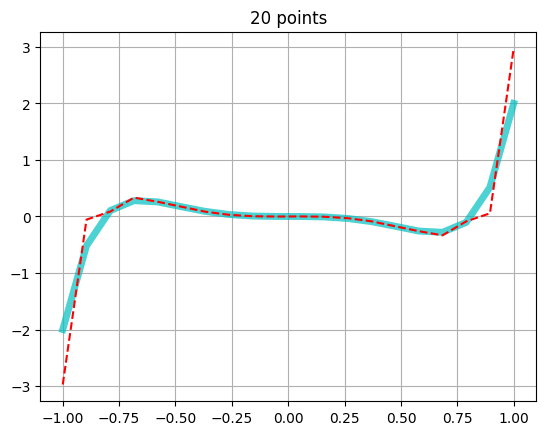

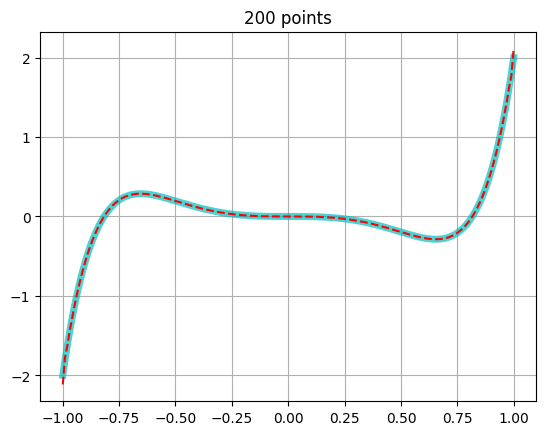

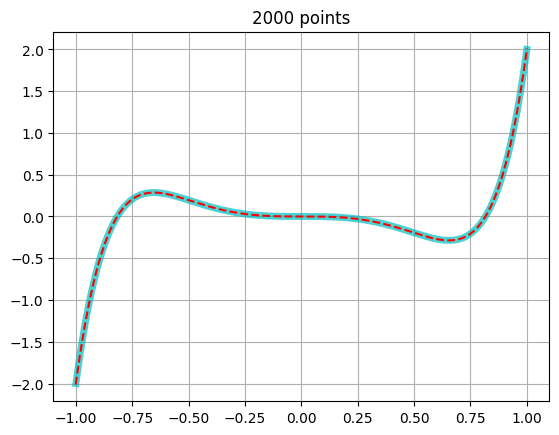

In [62]:
I1, I2, I3 = np.linspace(-1, 1, 20), np.linspace(-1, 1, 200), np.linspace(-1, 1, 2000)
a1, a2, a3 = proj_pw_linear_approx(f, I1), proj_pw_linear_approx(f, I2), proj_pw_linear_approx(f, I3)

plt.plot(I1, a1, '--', color='red', zorder=99)
plt.plot(I1, f(I1), 'c', linewidth=5.0, alpha=0.7)
plt.title("20 points")
plt.grid(True)
plt.show()

plt.plot(I2, a2, '--', color='red', zorder=99)
plt.plot(I2, f(I2), 'c', linewidth=5.0, alpha=0.7)
plt.title("200 points")
plt.grid(True)
plt.show()

plt.plot(I3, a3, '--', color='red', zorder=99)
plt.plot(I3, f(I3), 'c', linewidth=5.0, alpha=0.7)
plt.title("2000 points")
plt.grid(True)
plt.show()

As seen from the above plots, the more points, the more accurate the function is. While it is easy to see that the approximations with 200 and 2000 points are much more accurate than 20 points, there is no noticable difference between the two higher resolution intervals. However, when plotting the error for different intervals with increasing resolution.

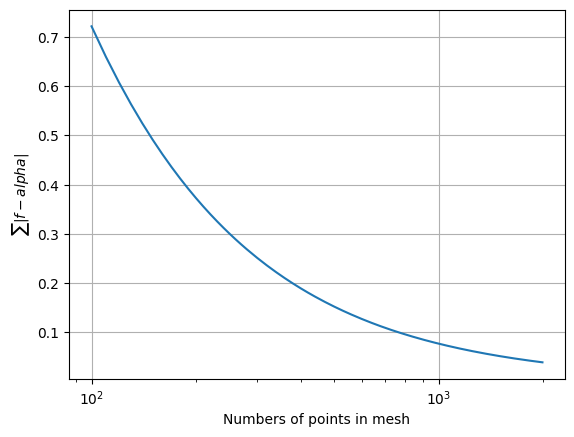

In [63]:
error = []
for length in range(100, 2000, 10):
    I = np.linspace(-1, 1, length)
    alpha = proj_pw_linear_approx(f, I)
    exact_f = f(I)
    error.append(np.sum(np.abs(exact_f - alpha)))
plt.plot(range(100, 2000, 10), error)
plt.ylabel("$\sum |f-alpha|$")
plt.xlabel("Numbers of points in mesh")
plt.xscale('log')
plt.grid(True)
plt.show()

When the resolution of the interval increases, the approximation converges towards the exact function. This means that the approximation is working as intended.

# **Discussion**
In comparison to the algorithm described in *Methods in Computational Science*, algorithm 9.2, this algorithm has a lower computational cost. Instead of integrating the vector and the matrix, the integrals are already pre-computed by solving them by hand first, as described in the book. However, this method also combines `add_to_global_vector`, `add_to_global_matrix` into the calculations directly and doesnt require an additional operation. The actual computational time of the two algorithms haven't been compared though.

I found that this implementation was much easier to follow than the given algorithm.